# Project 6: IMDB

This project involves NLP, decision trees, bagging, boosting, and more!

---

## Load packages

You are likely going to need to install the `imdbpie` package:

    > pip install imdbpie

---

In [1]:
import os
import subprocess
import collections
import re
import csv
import json
import math

import pandas as pd
import numpy as np
import scipy

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

import psycopg2
import requests
from imdbpie import Imdb
import nltk

import urllib
from bs4 import BeautifulSoup

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline

# set a random state to be used throughout
rs = 12

---

## Part 1: Acquire the Data

You will connect to the IMDB API to query for movies. 

See here for documentation on how to use the package:

https://github.com/richardasaurus/imdb-pie

#### 1. Connect to the IMDB API

In [2]:
imdb = Imdb()
imdb = Imdb(anonymize=True)

#### 2. Query the top 250 rated movies in the database

In [3]:
movies= imdb.top_250()

#### 3. Make a dataframe from the movie data

Keep the fields:

    num_votes
    rating
    tconst
    title
    year
    
And discard the rest

In [4]:
top250 = pd.DataFrame(movies)[['num_votes','rating', 'tconst', 'title', 'year']]

In [5]:
top250.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 5 columns):
num_votes    250 non-null int64
rating       250 non-null float64
tconst       250 non-null object
title        250 non-null object
year         250 non-null object
dtypes: float64(1), int64(1), object(3)
memory usage: 9.8+ KB


In [6]:
# convert year to int
top250.year = top250.year.astype(int)

#### 3. Select only the top 100 movies

In [7]:
top100 = top250.sort_values('rating', ascending=False)[0:100]
print top100.info()
top100.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 128
Data columns (total 5 columns):
num_votes    100 non-null int64
rating       100 non-null float64
tconst       100 non-null object
title        100 non-null object
year         100 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.7+ KB
None


,num_votes,rating,tconst,title,year
0,1658585,9.3,tt0111161,The Shawshank Redemption,1994
1,1135260,9.2,tt0068646,The Godfather,1972
2,775312,9.0,tt0071562,The Godfather: Part II,1974
3,1644294,9.0,tt0468569,The Dark Knight,2008
7,1193602,8.9,tt0167260,The Lord of the Rings: The Return of the King,2003


#### 4. Get the genres and runtime for each movie and add them to the dataframe

There can be multiple genres per movie, so this will need some finessing.

In [8]:
# function to convert string to list of strings, removing whitespace
# from start and end (to use for getting lists of genres)
def strtolist(string):
    result = []
    current = ""
    for c in string:
        if c == ",":
            result.append(current.strip())
            current=""
        else:
            current+=(c)
    result.append(current.strip())
    return result

In [9]:
# create dictionary of movie id: {dictionary of genres and runtimes}
# also create list of all genres across all movies
allgenres=[]
genreruntime = {}
for mID in top100.tconst:
    url = "http://www.omdbapi.com/?i="+mID
    data = urllib.urlopen(url)
    parsed_data = json.loads(data.read())
    genres = strtolist(parsed_data["Genre"])
    runtime = parsed_data["Runtime"]
    rt = int(runtime[0:(len(runtime)-4)])
    genreruntime[mID] = {'genres': genres, 'runtime': rt}
    for genre in genres:
        if genre not in allgenres:
            allgenres.append(genre)

In [10]:
# add columns for Runtime and Genres to dataframe
top100["runtime_mins"] = np.nan
for genre in allgenres:
    top100[genre] = 0

In [11]:
# populate our new columns with values for each movie
for mID in top100.tconst:
    i = top100[top100['tconst']==mID].index
    top100.set_value(i, 'runtime_mins', genreruntime[mID]['runtime'])
    for genre in genreruntime[mID]['genres']:
        top100.set_value(i, genre, 1)

In [13]:
# look at % of top 100 that genre constitutes (sum is >100% due to 
# some movies having multiple genres). Make sure all nonzero
top100[allgenres].sum().sort_values(ascending=False)/top100.tconst.count()

Drama        0.71
Crime        0.25
Adventure    0.22
Action       0.17
Mystery      0.15
Thriller     0.14
Comedy       0.12
Sci-Fi       0.10
Biography    0.09
Fantasy      0.09
Animation    0.08
Romance      0.07
War          0.07
Family       0.06
History      0.04
Horror       0.04
Western      0.03
Film-Noir    0.03
Music        0.01
Sport        0.01
dtype: float64

In [123]:
# change scifi and film noir column headers to avoid "-" char
top100.rename(columns = {'Sci-Fi': 'Sci_Fi', 'Film-Noir': 'Film_Noir'}, inplace=True)

Index([   u'num_votes',       u'rating',       u'tconst',        u'title',
               u'year', u'runtime_mins',        u'Crime',        u'Drama',
             u'Action',     u'Thriller',    u'Adventure',      u'Fantasy',
            u'Western',    u'Biography',      u'History',      u'Romance',
            u'Mystery',       u'Sci_Fi',          u'War',       u'Comedy',
          u'Animation',       u'Family',       u'Horror',    u'Film_Noir',
              u'Music',        u'Sport'],
      dtype='object')

#### 4. Write the Results to a csv

In [128]:
top100.to_csv('top100.csv', encoding='utf-8', index=False)

---

## Part 2: Wrangle the text data

#### 1. Scrape the reviews for the top 100 movies

*Hint*: Use a loop to scrape each page at once

In [41]:
# use imdbpie because of issues classmates reported with using beautiful soup
top100reviews= {}
for mID in top100.tconst:
    reviews = imdb.get_title_reviews(mID, max_results=10000)
    revlist = []
    for review in reviews:
        revdict = {'revText': review.text, 'revRating': review.rating}
        revlist.append(revdict)
    top100reviews[mID] = revlist
    
print len(top100reviews)

100


#### 2. Extract the reviews and the rating per review for each movie

*Note*: "soup" from BeautifulSoup is the html returned from all 25 pages. You'll need to either address each page individually or break them down by elements.

#### 3. Remove the non AlphaNumeric characters from reviews

In [141]:
# use regex to strip alphanumeric chars from each review and separately
# make list of all reviews
allReviews = []
for movie in top100reviews:
    for i in range(len(top100reviews[movie])):
        strippedText = re.sub(r'([^\s\w]|_)+', '', top100reviews[movie][i]['revText']).replace('\n', ' ')
        allReviews.append(strippedText)
        top100reviews[movie][i]['revText'] = strippedText

In [142]:
allReviews[1]

u'Taking the festival circuit by storm since its Sundance premiere in January Whiplash is starting to feel like the underdog that could go far with its crowdpleasing intensity On the surface its a gritty story about a brutal studentmentor relationship that oversteps boundaries Underneath its a piercing examination of the psyche of unbridled ambition Whiplash is a film that stops at nothing As a result its the best film Ive seen in years and I say that without hesitation This is a film that resonates on every single level and every moment counts If writerdirector Damien Chazelle was striving for greatness as much as his protagonist then he has achieved it   Miles Teller whos been steadily growing on me since The Spectacular Now stars as Andrew Neyman a 19yearold aspiring jazz drummer whos pushed and inspired by the abuse and aspirations of his school band leader Fletcher played by the ferocious JK Simmons like weve never seen him before Chazelle has described the film as an origin story

#### 4. Calculate the top 200 ngrams from the user reviews

Use the `TfidfVectorizer` in sklearn.

Recommended parameters:

    ngram_range = (1, 2)
    stop_words = 'english'
    binary = False
    max_features = 200

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
tvect = TfidfVectorizer(ngram_range = (1,2), stop_words='english', max_features=200)

In [20]:
# train tvect on all reviews
tdm = tvect.fit_transform(allReviews)

In [21]:
tvect.get_feature_names()

[u'10',
 u'acting',
 u'action',
 u'actor',
 u'actors',
 u'actually',
 u'amazing',
 u'american',
 u'audience',
 u'away',
 u'bad',
 u'batman',
 u'battle',
 u'beautiful',
 u'believe',
 u'best',
 u'better',
 u'big',
 u'bit',
 u'black',
 u'book',
 u'brilliant',
 u'cast',
 u'character',
 u'characters',
 u'christopher',
 u'cinema',
 u'cinematography',
 u'classic',
 u'come',
 u'comes',
 u'completely',
 u'course',
 u'dark',
 u'dark knight',
 u'day',
 u'death',
 u'definitely',
 u'did',
 u'didnt',
 u'different',
 u'direction',
 u'director',
 u'does',
 u'doesnt',
 u'dont',
 u'effects',
 u'end',
 u'ending',
 u'epic',
 u'especially',
 u'excellent',
 u'experience',
 u'fact',
 u'family',
 u'fantastic',
 u'far',
 u'favorite',
 u'feel',
 u'felt',
 u'fight',
 u'film',
 u'films',
 u'final',
 u'finally',
 u'gets',
 u'gives',
 u'goes',
 u'going',
 u'good',
 u'got',
 u'great',
 u'greatest',
 u'guy',
 u'hard',
 u'having',
 u'help',
 u'hes',
 u'high',
 u'history',
 u'hope',
 u'hours',
 u'human',
 u'idea',
 u'i

#### 5. Merge the user reviews and ratings

In [143]:
# I am guessing that the requirement here is to create a 3-column dataframe
# with movie, review text and rating

top100revDF = pd.DataFrame(columns = ['mID', 'revText', 'revRating'])

for movie in top100reviews:
    for i in range(len(top100reviews[movie])):
        review = top100reviews[movie][i]
        top100revDF = top100revDF.append(pd.DataFrame([[movie, review['revText'], 
            review['revRating']]], columns = ['mID', 'revText', 'revRating']), 
            ignore_index=True)

#### 6. Save this merged dataframe as a csv

In [144]:
# change mID column to tconst, to line up with the top100 table

top100revDF['tconst'] = top100revDF['mID']
del top100revDF['mID']

In [160]:
# remove \r from reviews
top100revDF['revText'] = top100revDF['revText'].replace('\r', ' ').replace('\\n', ' ').replace('\\r',' ')

In [161]:
# remove null rows
nonnull = top100revDF.dropna()

In [162]:
nonnull.to_csv('reviews.csv', encoding='utf-8', index=False)

---

## Part 3: Combine Tables in PostgreSQL

#### 1. Import your two .csv data files into your Postgre Database as two different tables

For ease, we can call these table1 and table2

In [111]:
%load_ext sql

/Users/caitlingerrity/anaconda/lib/python2.7/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/Users/caitlingerrity/anaconda/lib/python2.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


In [120]:
%%sql 
postgresql://localhost:5432/imdb


u'Connected: None@imdb'

In [399]:
%%sql
DROP TABLE IF EXISTS top100;
CREATE TABLE top100
(num_votes integer,
rating decimal,
tconst text,
title text,
year integer,
runtime_mins numeric,
Crime integer,
Drama integer,
Action integer,
Thriller integer,
Adventure integer,
Fantasy integer,
Western integer,
Biography integer,
History integer,
Romance integer,
Mystery integer,
Sci_Fi integer,
War integer,
Comedy integer,
Animation integer,
Family integer,
Horror integer,
Film_Noir integer,
Music integer,
Sport integer
);

COPY top100 FROM
'/Users/caitlingerrity/Desktop/GA_Course_files/Python/Projects/GA-DSI-Project6/top100.csv'
DELIMITER ',' CSV HEADER;

Done.
Done.
100 rows affected.


[]

In [401]:
%%sql
DROP TABLE IF EXISTS reviews;
CREATE TABLE reviews 
(revText text,
 revRating decimal,
 tconst text
);

COPY reviews FROM 
'/Users/caitlingerrity/Desktop/GA_Course_files/Python/Projects/GA-DSI-Project6/reviews.csv'
DELIMITER ',' CSV HEADER;

Done.
Done.
94068 rows affected.


[]

#### 2. Connect to database and query the joined set

In [402]:
joined = %sql SELECT * FROM reviews JOIN top100 ON reviews."tconst"=top100."tconst";

93010 rows affected.


#### 3. Join the two tables 

In [403]:
result = pd.DataFrame(joined, columns = (nonnull.columns).append(top100.columns))

In [404]:
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93010 entries, 0 to 93009
Data columns (total 29 columns):
revText         93010 non-null object
revRating       93010 non-null object
tconst          93010 non-null object
num_votes       93010 non-null int64
rating          93010 non-null object
tconst          93010 non-null object
title           93010 non-null object
year            93010 non-null int64
runtime_mins    93010 non-null object
Crime           93010 non-null int64
Drama           93010 non-null int64
Action          93010 non-null int64
Thriller        93010 non-null int64
Adventure       93010 non-null int64
Fantasy         93010 non-null int64
Western         93010 non-null int64
Biography       93010 non-null int64
History         93010 non-null int64
Romance         93010 non-null int64
Mystery         93010 non-null int64
Sci_Fi          93010 non-null int64
War             93010 non-null int64
Comedy          93010 non-null int64
Animation       93010 non-null in

#### 4. Select the newly joined table and save two copies of the into dataframes

In [4]:
# reading in the tables because I had to restart computer
nonnull = pd.read_csv('reviews.csv')
top100 = pd.read_csv('top100.csv')

In [5]:
## code in case of problems with the SQL data
df = top100.merge(nonnull)

In [391]:
## had to abandon this code because of issues with converting values back to numeric
#df = result.drop(['tconst', 'title'], axis=1) 

In [6]:
df.head()

,num_votes,rating,tconst,title,year,runtime_mins,Crime,Drama,Action,Thriller,...,War,Comedy,Animation,Family,Horror,Film_Noir,Music,Sport,revText,revRating
0,1658585,9.3,tt0111161,The Shawshank Redemption,1994,142.0,1,1,0,0,...,0,0,0,0,0,0,0,0,Why do I want to write the 234th comment on Th...,10.0
1,1658585,9.3,tt0111161,The Shawshank Redemption,1994,142.0,1,1,0,0,...,0,0,0,0,0,0,0,0,Can Hollywood usually creating things for ent...,10.0
2,1658585,9.3,tt0111161,The Shawshank Redemption,1994,142.0,1,1,0,0,...,0,0,0,0,0,0,0,0,In its Oscar year Shawshank Redemption written...,10.0
3,1658585,9.3,tt0111161,The Shawshank Redemption,1994,142.0,1,1,0,0,...,0,0,0,0,0,0,0,0,I believe that this film is the best story ev...,8.0
4,1658585,9.3,tt0111161,The Shawshank Redemption,1994,142.0,1,1,0,0,...,0,0,0,0,0,0,0,0,One of my all time favorites Shawshank Redemp...,10.0


---

## Part 4: Parsing and Exploratory Data Analysis

#### 1. Rename any columns you think should be renamed for clarity

In [7]:
df.columns

Index([u'num_votes', u'rating', u'tconst', u'title', u'year', u'runtime_mins',
       u'Crime', u'Drama', u'Action', u'Thriller', u'Adventure', u'Fantasy',
       u'Western', u'Biography', u'History', u'Romance', u'Mystery', u'Sci_Fi',
       u'War', u'Comedy', u'Animation', u'Family', u'Horror', u'Film_Noir',
       u'Music', u'Sport', u'revText', u'revRating'],
      dtype='object')

In [8]:
df.rename(columns = {'rating': 'avgRating'}, inplace=True)
# drop title and tconst since they won't be used for modeling
df.drop(['tconst', 'title'], axis=1, inplace=True)

#### 2. Describe anything interesting or suspicious about your data (quality assurance)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93010 entries, 0 to 93009
Data columns (total 26 columns):
num_votes       93010 non-null int64
avgRating       93010 non-null float64
year            93010 non-null int64
runtime_mins    93010 non-null float64
Crime           93010 non-null int64
Drama           93010 non-null int64
Action          93010 non-null int64
Thriller        93010 non-null int64
Adventure       93010 non-null int64
Fantasy         93010 non-null int64
Western         93010 non-null int64
Biography       93010 non-null int64
History         93010 non-null int64
Romance         93010 non-null int64
Mystery         93010 non-null int64
Sci_Fi          93010 non-null int64
War             93010 non-null int64
Comedy          93010 non-null int64
Animation       93010 non-null int64
Family          93010 non-null int64
Horror          93010 non-null int64
Film_Noir       93010 non-null int64
Music           93010 non-null int64
Sport           93010 non-null int64

#### 3. Make four visualizations of interest to you using the data

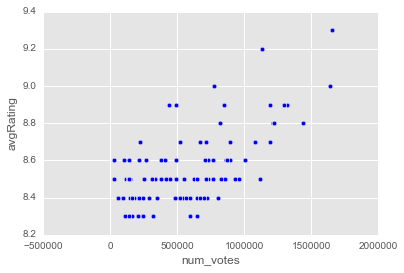

In [10]:
# do more votes correspond with higher avg rating?
plt.scatter(df['num_votes'], df['avgRating'])
plt.xlabel("num_votes")
plt.ylabel("avgRating")

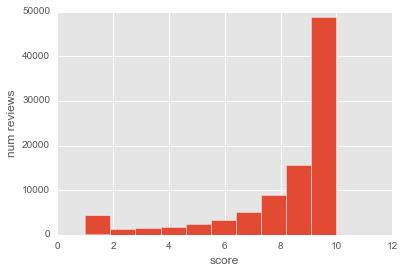

In [11]:
# What does distribution of ratings look like?
plt.hist(df['revRating'])
plt.xlabel("score")
plt.ylabel("num reviews")

# 1 seems to be most heavily used of low scores - when people dislike
# a movie they just score it at 1 rather than bother distinguishing between 1-4 (ish).
# Another interpretation is that people whose true opinion of a movie is middling
# (between, say, 2-7 rating equivalent) aren't as motivated to share their opinion as
# those who either loved or hated the movie.

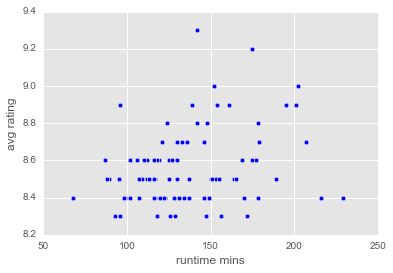

In [12]:
# look at avg rating vs runtime
plt.scatter(df['runtime_mins'], df['avgRating'])
plt.xlabel('runtime mins')
plt.ylabel('avg rating')

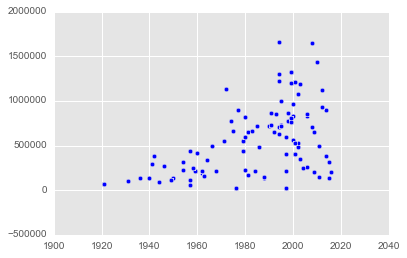

In [13]:
# num votes versus year (are fewer people voting on older movies?)

plt.scatter(df['year'], df['num_votes'])

---

## Part 5: Decision Tree Classifiers and Regressors

#### 1. What is our target attribute? 

Choose a target variable for the decision tree regressor and the classifier. 

## Target Variable: revRating

10 possible classes.

#### 2. Prepare the X and Y matrices and preprocess data as you see fit

In [14]:
df.columns

Index([u'num_votes', u'avgRating', u'year', u'runtime_mins', u'Crime',
       u'Drama', u'Action', u'Thriller', u'Adventure', u'Fantasy', u'Western',
       u'Biography', u'History', u'Romance', u'Mystery', u'Sci_Fi', u'War',
       u'Comedy', u'Animation', u'Family', u'Horror', u'Film_Noir', u'Music',
       u'Sport', u'revText', u'revRating'],
      dtype='object')

Note: below cell is to create y with 5 classes instead of 10. Keeping this in case I decide to use it later, but I'll use all 10 classes for now. 

Based on the distribution of the ratings, this code creates the following target classes:
A: score 10
B: score 8-9
C: score 6-7
D: score 2-5
F: score 1

In [15]:
# # function to convert scores to grades A-F
# def convertToGrade(y):
#     if y == 1: return 'F'
#     elif y < 6: return 'D'
#     elif y < 8: return 'C'
#     elif y <10: return 'B'
#     elif y == 10: return 'A'
#     else: return np.nan
    
# # define y as grades

# y = pd.DataFrame([convertToGrade(y) for y in df['revRating']], columns = ['Grade'])

In [16]:
# define X, y
y = df['revRating']
X = df.drop(['num_votes', 'avgRating', 'revText', 'revRating'], axis=1)

In [17]:
y.head()

0    10.0
1    10.0
2    10.0
3     8.0
4    10.0
Name: revRating, dtype: float64

In [23]:
# Need to add tfidf columns to the dataset
dft = pd.DataFrame(tvect.transform(df['revText']).toarray(), columns = tvect.get_feature_names())

In [24]:
X = pd.concat([X, dft], axis = 1)

In [75]:
X.columns

Index([        u'year', u'runtime_mins',        u'Crime',        u'Drama',
             u'Action',     u'Thriller',    u'Adventure',      u'Fantasy',
            u'Western',    u'Biography',
       ...
            u'watched',     u'watching',          u'way',    u'wonderful',
               u'work',        u'world',        u'worth',         u'year',
              u'years',        u'young'],
      dtype='object', length=222)

In [89]:
# there are 2 'year' columns, one for release year and one for the word 'year' in a review. Need to rename
newColHeaders = X.columns[1:].tolist()
newColHeaders.insert(0, "ReleaseYear")

In [91]:
X.columns = newColHeaders

#### 3. Build and cross-validate your decision tree classifier

In [26]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

In [27]:
# instantiate classifier, use max_depth of 4 to control complexity
dt = DecisionTreeClassifier(max_depth = 4, random_state = rs)

In [28]:
dt.fit(X,y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=12, splitter='best')

In [29]:
cvscores = cross_val_score(dt, X, y, n_jobs = -1)
print cvscores
print cvscores.mean()

[ 0.52451138  0.3983808   0.49475823]
0.472550140119


#### 4. Gridsearch optimal parameters for your classifier. Does the performance improve?

In [30]:
# set up param grid
param_grid = {
    'max_depth': [None,2,4,6,8,10],
    'min_samples_split': range(5,100,10),
    'max_features': [None, 10, 100]
}

In [31]:
# instantiate gridsearchcv
gsdt = GridSearchCV(dt, param_grid, n_jobs=-1, verbose=1)

In [32]:
gsdt.fit(X,y)

Fitting 3 folds for each of 180 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   55.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  4.2min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=12, splitter='best'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'min_samples_split': [5, 15, 25, 35, 45, 55, 65, 75, 85, 95], 'max_features': [None, 10, 100], 'max_depth': [None, 2, 4, 6, 8, 10]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

In [33]:
gsdt.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=10, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            presort=False, random_state=12, splitter='best')

In [34]:
cvscores = cross_val_score(gsdt.best_estimator_, X, y)
print cvscores
print cvscores.mean()

[ 0.52451138  0.50208044  0.52456372]
0.517051850824


In [35]:
gsdt_pred = gsdt.predict(X)
print classification_report(y, gsdt_pred)

             precision    recall  f1-score   support

        1.0       0.00      0.00      0.00      4282
        2.0       0.00      0.00      0.00      1326
        3.0       0.00      0.00      0.00      1617
        4.0       0.00      0.00      0.00      1709
        5.0       0.00      0.00      0.00      2397
        6.0       0.00      0.00      0.00      3298
        7.0       0.00      0.00      0.00      5052
        8.0       0.00      0.00      0.00      8889
        9.0       0.00      0.00      0.00     15653
       10.0       0.52      1.00      0.69     48787

avg / total       0.28      0.52      0.36     93010



/Users/caitlingerrity/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The mean cv score improved with this model, but the model is just classifying every single review as a rating of 10, which is not very helpful!

#### 5. Build and cross-validate your decision tree regressor

In [36]:
dtr = DecisionTreeRegressor(random_state=rs)

In [37]:
dtr.fit(X,y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=12,
           splitter='best')

In [38]:
cvscores = cross_val_score(dtr, X, y)
print cvscores
print cvscores.mean()
# due to a quirk in sklearn, MSE is displayed as negative from cross val score

[-0.59364228 -0.63710682 -0.65970923]
-0.63015277666


In [39]:
dtr_pred = dtr.predict(X)

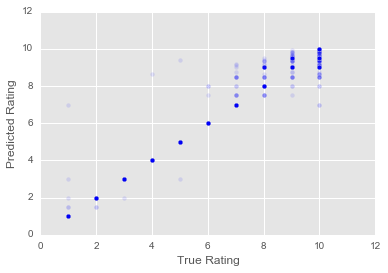

In [40]:
# look at true vs predicted
plt.scatter(y, dtr_pred, alpha=.1)
plt.xlabel("True Rating")
plt.ylabel("Predicted Rating")

#### 6. Gridsearch the optimal parameters for your regressor. Does performance improve?

In [41]:
# instantiate gs, use same param grid as previous
gsdtr = GridSearchCV(dtr, param_grid, n_jobs=-1, verbose=1)

In [42]:
gsdtr.fit(X,y)

Fitting 3 folds for each of 180 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  4.5min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=12,
           splitter='best'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'min_samples_split': [5, 15, 25, 35, 45, 55, 65, 75, 85, 95], 'max_features': [None, 10, 100], 'max_depth': [None, 2, 4, 6, 8, 10]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

In [43]:
gsdtr.best_estimator_

DecisionTreeRegressor(criterion='mse', max_depth=6, max_features=100,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=15,
           min_weight_fraction_leaf=0.0, presort=False, random_state=12,
           splitter='best')

In [44]:
cvscores = cross_val_score(gsdtr.best_estimator_, X, y)
print cvscores
print cvscores.mean()

[ 0.08597623  0.11571926  0.06369326]
0.08846291709


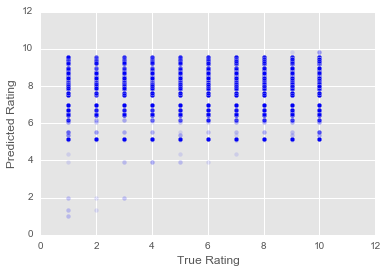

In [45]:
gsdtr_pred = gsdtr.predict(X)
plt.scatter(y, gsdtr_pred, alpha= .1)
plt.xlabel("True Rating")
plt.ylabel("Predicted Rating")

---

## Part 6: Elastic Net


#### 1. Gridsearch optimal parameters for an ElasticNet using the regression target and predictors you used for the decision tree regressor.


In [46]:
# Never learned Elastic Net

#### 2. Is cross-validated performance better or worse than with the decision trees? 

#### 3. Explain why the elastic net may have performed best at that particular l1_ratio and alpha

---

## Part 7: Bagging and Boosting: Random Forests, Extra Trees, and AdaBoost

#### 1. Load the random forest regressor, extra trees regressor, and adaboost regressor from sklearn

In [47]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor
rfr = RandomForestRegressor(random_state=rs, n_jobs=-1, verbose=1)
abr = AdaBoostRegressor(random_state=rs)
etr = ExtraTreesRegressor(random_state=rs,n_jobs=-1, verbose=1)

#### 2. Gridsearch optimal parameters for the three different ensemble methods.

In [51]:
# Random Forest
# param_grid = {
#     'max_features': [None,5,20],
#     'max_depth':[None,5,10],
#     'min_samples_split': [2,10,40]
# }

param_grid = {'max_depth':[None,5,10]}

In [52]:
gsrfr = GridSearchCV(rfr, param_grid, verbose=1)

In [53]:
# after trying lots of different param_grid inputs, I'm still having this weird issue
# where fit() runs indefinitely, with verbose just repeating "done 10 out of 10" over and over.
# Just going to fit rfr itself for now and come back if I have time.
gsrfr.fit(X,y)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   17.8s finished
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished


KeyboardInterrupt: 

In [54]:
rfr.fit(X,y)

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   29.7s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=-1, oob_score=False, random_state=12,
           verbose=1, warm_start=False)

In [55]:
abr.fit(X,y)

AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=50, random_state=12)

In [56]:
etr.fit(X,y)

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   31.9s finished


ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=10, n_jobs=-1, oob_score=False, random_state=12,
          verbose=1, warm_start=False)

#### 3. Evaluate the performance of the two bagging and one boosting model. Which performs best?

In [57]:
rfr_cvscores = cross_val_score(rfr, X,y, n_jobs = -1)

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   52.1s finished
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   52.5s finished
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   52.3s finished
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished


In [60]:
abr_cvscores = cross_val_score(abr, X,y, n_jobs = -1)

In [61]:
etr_cvscores = cross_val_score(etr, X,y, n_jobs = -1)

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   52.3s finished
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   51.8s finished
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   53.7s finished
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished


In [62]:
print "Random Forest cvscore:", rfr_cvscores.mean()
print "AdaBoost cvscore:", abr_cvscores.mean()
print "ExtraTrees cvscore:", etr_cvscores.mean()

Random Forest cvscore: 0.110885261311
AdaBoost cvscore: -0.0312945806553
ExtraTrees cvscore: 0.11728145449


In [111]:
# use train_test_split and test performance
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=rs)

In [112]:
# fit models on training data
rfr.fit(X_train, y_train)
abr.fit(X_train, y_train)
etr.fit(X_train, y_train)
dtr.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   26.6s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   25.5s finished


DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=12,
           splitter='best')

In [113]:
rfr_pred_test = rfr.predict(X_test)
abr_pred_test = abr.predict(X_test)
etr_pred_test = etr.predict(X_test)
dtr_pred_test = dtr.predict(X_test)

[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished


In [116]:
# look at RMSE for each model - also compare with our decision tree regressor that performed OK-ish earlier
print "RFR RMSE: ", np.mean([math.pow(pred-true, 2) for pred, true in zip(rfr_pred_test, y_test)])
print "ABR RMSE: ", np.mean([math.pow(pred-true, 2) for pred, true in zip(abr_pred_test, y_test)])
print "ETR RMSE: ", np.mean([math.pow(pred-true, 2) for pred, true in zip(etr_pred_test, y_test)])
print "Decision Tree RMSE: ", np.mean([math.pow(pred-true, 2) for pred, true in zip(dtr_pred_test, y_test)])

RFR RMSE:  5.02202738378
ABR RMSE:  6.59956937488
ETR RMSE:  4.90757170283
Decision Tree RMSE:  9.22344808249


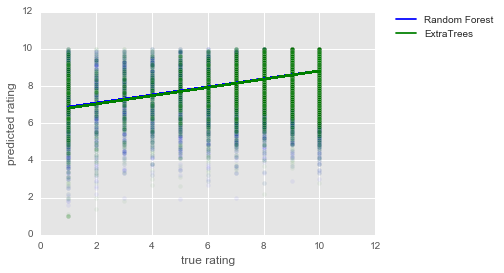

In [119]:
# ETR and RFR performed the best: look at them on a plot
plt.scatter(y_test, rfr_pred_test, c = 'blue', alpha = .05)
m_rtr, b_rtr = np.polyfit(y_test, rfr_pred_test, 1)
plt.plot(y_test, y_test*m_rtr+b_rtr, c='blue')
plt.scatter(y_test, etr_pred_test, c = 'green', alpha = .05)
m_etr, b_etr = np.polyfit(y_test, etr_pred_test, 1)
plt.plot(y_test, y_test*m_etr+b_etr, c='green')
plt.xlabel("true rating")
plt.ylabel("predicted rating")
plt.legend(['Random Forest', 'ExtraTrees'], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

These models are generally overestimating ratings. It is possible that this is due in part to our data being so skewed to high ratings: we simply don't have sufficient training data to learn how to predict low ratings. Given that our data mostly has high ratings, our model is correctly predicting higher ratings generally because they're more likely to be correct. A better training set would have an equal distribution of true ratings.

#### 4. Extract the feature importances from the Random Forest regressor and make a DataFrame pairing variable names with their variable importances.

In [120]:
importances = pd.DataFrame(zip(X.columns, rfr.feature_importances_), columns = ['Variable', 
    'Importance']).sort_values('Importance', ascending = False)


In [121]:
importances.head(20)

,Variable,Importance
0,ReleaseYear,0.034835
32,bad,0.034722
37,best,0.032596
114,just,0.019705
91,good,0.019548
140,movie,0.016999
1,runtime_mins,0.015780
121,like,0.014996
151,people,0.014613
158,plot,0.014278


#### 5. Plot the ranked feature importances.

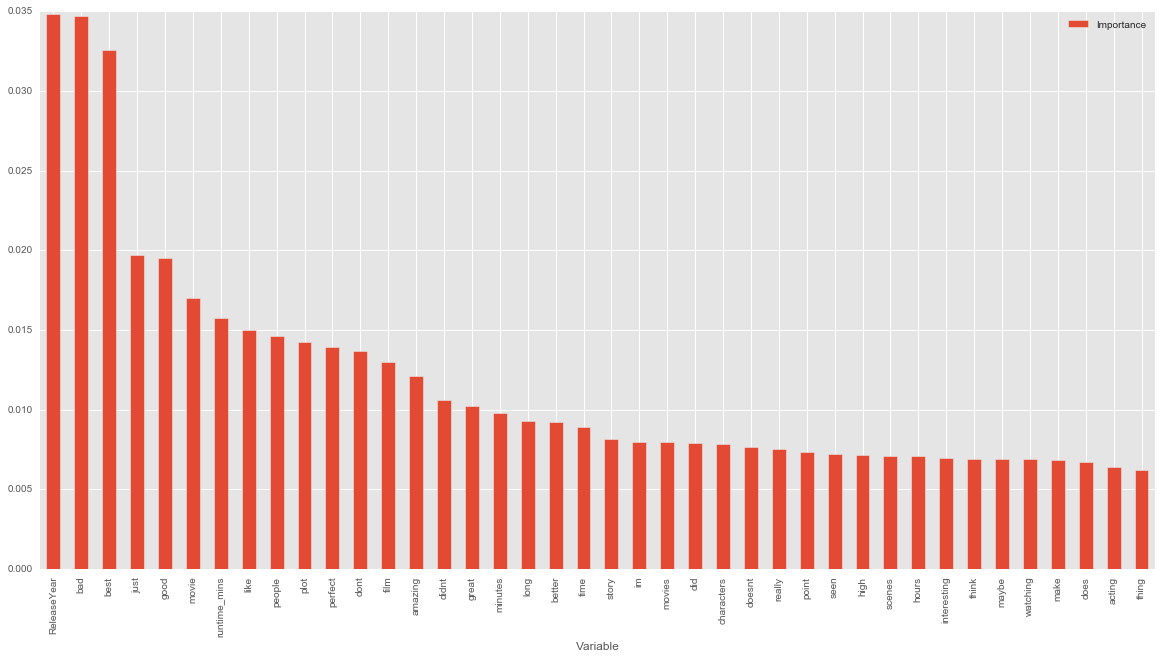

In [122]:
# plot only top 40 features to avoid cluttering (top 16 have >1% importance)
importances.head(40).plot(kind='bar', x = 'Variable', y = 'Importance', figsize = (20,10))

In [108]:
# summary stats for report
top100.describe(percentiles=None, include='all', exclude=None)

,num_votes,rating,tconst,title,year,runtime_mins,Crime,Drama,Action,Thriller,...,Mystery,Sci_Fi,War,Comedy,Animation,Family,Horror,Film_Noir,Music,Sport
count,1.000000e+02,100.000000,100,100,100.00000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.00000,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000,100.000000,100.00,100.00
unique,NaN,NaN,100,100,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,tt0095765,Goodfellas,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,1,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,5.407041e+05,8.540000,NaN,NaN,1984.23000,135.720000,0.250000,0.710000,0.170000,0.140000,...,0.15000,0.100000,0.070000,0.120000,0.08000,0.060000,0.040000,0.030000,0.01,0.01
std,3.908246e+05,0.201008,NaN,NaN,23.07557,37.285435,0.435194,0.456048,0.377525,0.348735,...,0.35887,0.301511,0.256432,0.326599,0.27266,0.238683,0.196946,0.171447,0.10,0.10
min,2.531700e+04,8.300000,NaN,NaN,1921.00000,68.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00,0.00
25%,2.092492e+05,8.400000,NaN,NaN,1967.50000,111.500000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00,0.00
50%,4.888295e+05,8.500000,NaN,NaN,1991.50000,129.500000,0.000000,1.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00,0.00
75%,7.835982e+05,8.600000,NaN,NaN,2001.00000,154.250000,0.250000,1.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00,0.00


In [109]:
# summary stats for report
nonnull.describe(percentiles=None, include='all', exclude=None)

,revText,revRating,tconst
count,94068,94068.000000,94068
unique,93673,NaN,100
top,This is by far the best movie ever to give a p...,NaN,tt0468569
freq,16,NaN,4440
mean,NaN,8.446602,NaN
std,NaN,2.443969,NaN
min,NaN,1.000000,NaN
25%,NaN,8.000000,NaN
50%,NaN,10.000000,NaN
75%,NaN,10.000000,NaN


#### 6.1 [BONUS] Gridsearch an optimal Lasso model and use it for variable selection (make a new predictor matrix with only the variables not zeroed out by the Lasso). 

#### 6.2 [BONUS] Gridsearch your best performing bagging/boosting model from above with the features retained after the Lasso. Does the score improve?

#### 7.1. [BONUS] Select a threshold for variable importance from your Random Forest regressor and use that to perform feature selection, creating a new subset predictor matrix.

#### 7.2 [BONUS] Using BaggingRegressor with a base estimator of your choice, test a model using the feature-selected dataset you made in 7.1

---

## [VERY BONUS] Part 8: PCA

#### 1. Perform a PCA on your predictor matrix

#### 2. Examine the variance explained and determine what components you want to keep based on them.

#### 3. Plot the cumulative variance explained by the ordered principal components.

#### 4. Gridsearch an elastic net using the principal components you selected as your predictors. Does this perform better than the elastic net you fit earlier?

#### 5. Gridsearch a bagging ensemble estimator that you fit before, this time using the principal components as predictors. Does this perform better or worse than the original? 

#### 6. Look at the loadings of the original predictor columns on the first 3 principal components. Is there any kind of intuitive meaning here?

Hint, you will probably want to sort by absolute value of magnitude of loading, and also only look at the obviously important (larger) ones!

# [Extremely Bonus] Part 9:  Clustering

![](https://snag.gy/jPSZ6U.jpg)

 ***Bonus Bonus:***
This extended bonus question is asking to do something we never really talked about but would like for you to attempt based on the assumptions that we learned during this weeks clustering lesson(s).

#### 1. Import your favorite clustering module

#### 2. Encode categoricals

#### 3. Evaluate cluster metics solely based on a range of K
If K-Means:  SSE/Inertia vs Silhouette (ie: Elbow), silhouette average, etc

#### 4.  Look at your data based on the subset of your predicted clusters.
Assign the cluster predictions back to your dataframe in order to see them in context.  This is great to be able to group by cluster to get a sense of the data that clumped together.

#### 5. Describe your findings based on the predicted clusters 
_How well did it do?  What's good or bad?  How would you improve this? Does any of it make sense?_